# Sentiment Analysis

## Part 2: Word Embeddings and Neural Network

In this notebook you will learn a powerful method to represent word in the numerical way and apply it to a simply 2-layer network for classification.

**Outline**:

- Neural Network
- Word Embeddings


**Pipeline**

<img src="resources/pipeline.png" width="800px">

## Neural Network

For this section, we will introduce some basis about neural network and define a basic NN using PyTorch. I assume you have knowledge about **Logistic Regression**.

### Logistic Regression

There are two ways to build a model in PyTorch:

1. Define a new Model class from `nn.Module` base class. Override `__init__` and `forward`.
2. Define a `nn.Sequential` and add layers one by one

In [1]:
# import utils and set plt settings
import utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook

%matplotlib inline
%config InlineBackend.figure_format='retina'

ModuleNotFoundError: No module named 'emoji'

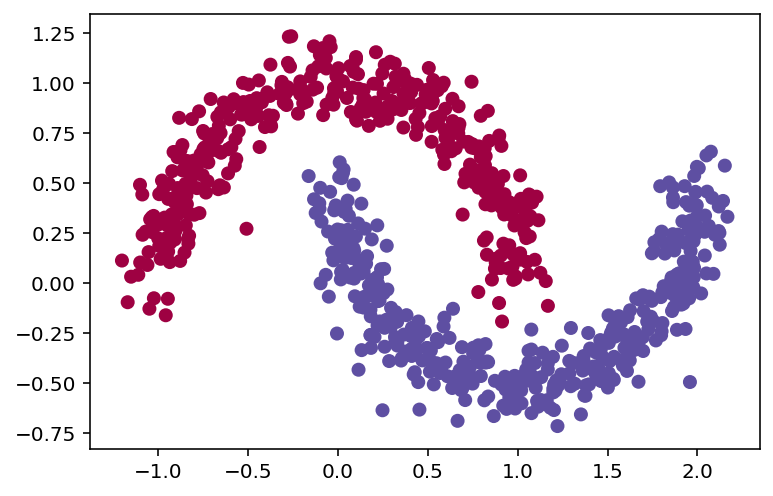

In [17]:
# Make and load Moon Dataset
train_x, test_x, train_y, test_y = utils.load_moon()

plt.scatter(
    train_x[:,0],     # first feature as x
    train_x[:,1],     # second feature as y
    c=train_y.T[0],   # label as color
    cmap=plt.cm.Spectral)

In [18]:
# These are 
print('type of train and test', type(train_x))
print('shape of X', train_x.shape)
print('shape of Y', train_y.shape)

type of train and test <class 'numpy.ndarray'>
shape of X (800, 2)
shape of Y (800, 1)


Generally speaking, Neural Network is the more general form of LR, which can be considered as a **1-Layer NN** (input layer doesn't count). 

<img src="resources/1-layer-nn.png">

<br>
<center>A 1-layer neural network: Logistic Regression</center>

In [19]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/nlp_proj/lib/python3.7/site-packages/tensorflow/python/frame

In [20]:
lr_model = Sequential()
lr_model.add(
    Dense(1, input_dim=2, activation='sigmoid')#fully connected layer全联网络（跟上层每一个节点都联通）
    #input_dim=2因为每个数据都有x，y
    #output_dim=1因为是output出去，只要一个神经元
    #以为是最后一层，所以激活函数用sigmoid
) # output layer 线性叠加的分类器结果
#sigmod是乘以一个正无穷/负无穷的系数，将结果压缩到[-1,+1]

lr_model.summary()
#三个需要学习的参数，因为方程是ax+by+c

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [25]:
#上一步是搭框架
#这一步是用compile给它额外信息，之后才能进行训练
#优化迭代的目标不是为了让accuracy最大，而是让loss最小
lr_model.compile(
    loss='binary_crossentropy',
    optimizer='sgd',#优化器：xy正常分布用sgd/gd/adam；如果xy的range分布相差太大，用rmsprop
    metrics=['accuracy'], )

In [47]:
lr_history = lr_model.fit(
    train_x, 
    train_y, 
    epochs=500, 
    #Intend to set a large number here for demonstration 迭代500次
    validation_data=(test_x, test_y), 
    #也看看测试数据的accuracy，从而及时发现overfit

SyntaxError: unexpected EOF while parsing (<ipython-input-47-1667762f650f>, line 7)

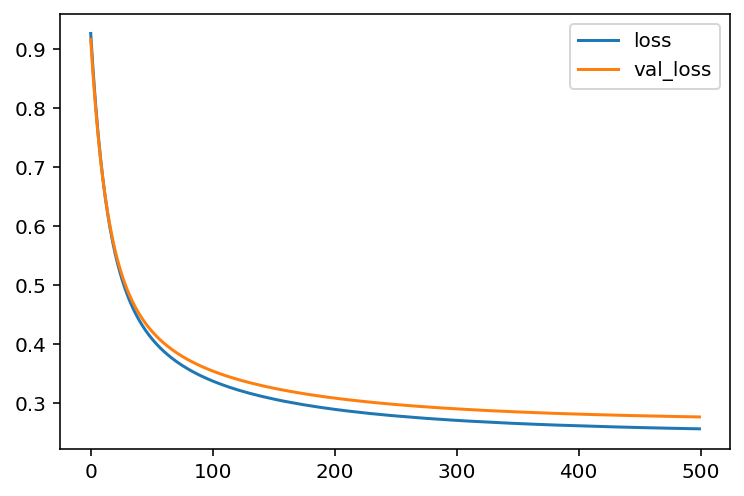

In [8]:
utils.plot_history(lr_history, ['loss', 'val_loss'])
#这个模型学习能力有限，loss不能达到一个很低的程度---》因为lr是一个线性模型，而这个数据是一个明显的非线性模型
#根据val——loss判断

In [9]:
lr_model.evaluate(test_x, test_y)

200/200 [==============================] - 0s 116us/sample - loss: 0.2764 - acc: 0.8500


[0.27638036489486695, 0.85]

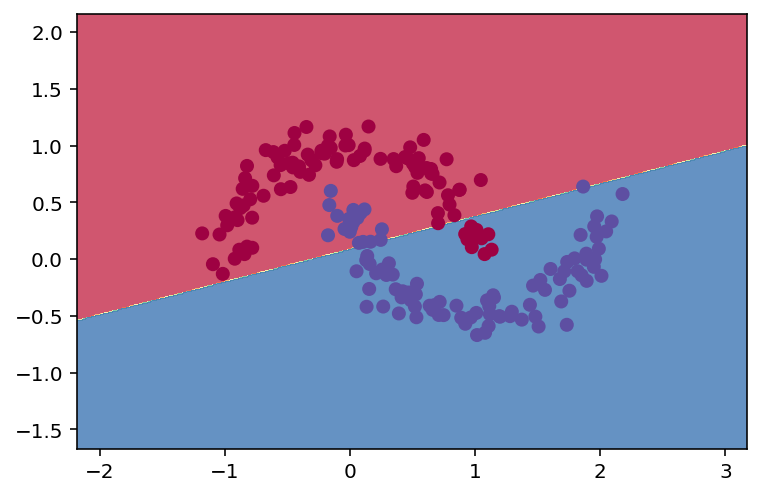

In [10]:
utils.plot_decision_boundary(lr_model, test_x, test_y)

### Neural Network

LR works not so well when features are not linearly separable. It depends heavily on features, so feature engineering is essential if you are using LR.

<img src="resources/2-layer-nn.png">

<br>
<center>A 2-layer neural network: 1 hidden layer + 1 output layer</center>

In [14]:
def build_nn_model(input_dim, layers, output_dim):
    # Input layer
    X = Input(shape=(input_dim,))
    
    # Hidden layer(s)
    H = X
    for layer in layers:
        H = Dense(layer, activation='relu')(H)#当layers多的时候 中间层千万别用sigmoid 因为会持续不下去 gradient vanishing
        #替换成relu或者tanh
    
    # Output layer
    activation_func = 'softmax' if output_dim > 1 else 'sigmoid'
    #最后一层 如果是单分类问题 使用sigmoid；如果是多分类问题 使用softmax（general version of sigmoid）
    
    Y = Dense(output_dim, activation=activation_func)(H)
    return Model(inputs=X, outputs=Y)

In [27]:
nn_model = build_nn_model(
    input_dim=2,
    layers=[8],#表示一层hidden layer8个神经元
    #[8，6]表示两层hidden layer 一层8个神经元 一层6个神经元
    output_dim=1
)
nn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [28]:
nn_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.02),
    metrics=['accuracy'],
)

In [29]:
nn_history = nn_model.fit(
    train_x, 
    train_y, 
    epochs=500, 
    validation_data=(test_x, test_y), )

Train on 800 samples, validate on 200 samples
Epoch 1/500
800/800 [==============================] - 0s 294us/sample - loss: 0.5620 - acc: 0.6625 - val_loss: 0.3748 - val_acc: 0.8100
Epoch 2/500
800/800 [==============================] - 0s 80us/sample - loss: 0.3097 - acc: 0.8487 - val_loss: 0.2920 - val_acc: 0.8500
Epoch 3/500
800/800 [==============================] - 0s 89us/sample - loss: 0.2553 - acc: 0.8813 - val_loss: 0.2551 - val_acc: 0.8650
Epoch 4/500
800/800 [==============================] - 0s 75us/sample - loss: 0.2347 - acc: 0.8938 - val_loss: 0.2567 - val_acc: 0.8700
Epoch 5/500
800/800 [==============================] - 0s 77us/sample - loss: 0.2284 - acc: 0.8950 - val_loss: 0.2493 - val_acc: 0.8850
Epoch 6/500
800/800 [==============================] - 0s 76us/sample - loss: 0.2301 - acc: 0.8963 - val_loss: 0.2353 - val_acc: 0.8650
Epoch 7/500
800/800 [==============================] - 0s 78us/sample - loss: 0.2251 - acc: 0.8938 - val_loss: 0.2275 - val_acc: 0.8800
E

800/800 [==============================] - 0s 47us/sample - loss: 0.2179 - acc: 0.8963 - val_loss: 0.2112 - val_acc: 0.8850
Epoch 61/500
800/800 [==============================] - 0s 45us/sample - loss: 0.2171 - acc: 0.8988 - val_loss: 0.2099 - val_acc: 0.8850
Epoch 62/500
800/800 [==============================] - 0s 45us/sample - loss: 0.2176 - acc: 0.8963 - val_loss: 0.2100 - val_acc: 0.8850
Epoch 63/500
800/800 [==============================] - 0s 48us/sample - loss: 0.2190 - acc: 0.9000 - val_loss: 0.2119 - val_acc: 0.8850
Epoch 64/500
800/800 [==============================] - 0s 49us/sample - loss: 0.2171 - acc: 0.8963 - val_loss: 0.2123 - val_acc: 0.8850
Epoch 65/500
800/800 [==============================] - 0s 50us/sample - loss: 0.2186 - acc: 0.8988 - val_loss: 0.2110 - val_acc: 0.8850
Epoch 66/500
800/800 [==============================] - 0s 45us/sample - loss: 0.2194 - acc: 0.8963 - val_loss: 0.2095 - val_acc: 0.8900
Epoch 67/500
800/800 [==============================] 

Epoch 120/500
800/800 [==============================] - 0s 46us/sample - loss: 0.2180 - acc: 0.8913 - val_loss: 0.2105 - val_acc: 0.8850
Epoch 121/500
800/800 [==============================] - 0s 44us/sample - loss: 0.2195 - acc: 0.9000 - val_loss: 0.2138 - val_acc: 0.8900
Epoch 122/500
800/800 [==============================] - 0s 44us/sample - loss: 0.2176 - acc: 0.8963 - val_loss: 0.2099 - val_acc: 0.8850
Epoch 123/500
800/800 [==============================] - 0s 43us/sample - loss: 0.2214 - acc: 0.8913 - val_loss: 0.2120 - val_acc: 0.8800
Epoch 124/500
800/800 [==============================] - 0s 45us/sample - loss: 0.2186 - acc: 0.9000 - val_loss: 0.2121 - val_acc: 0.8850
Epoch 125/500
800/800 [==============================] - 0s 44us/sample - loss: 0.2180 - acc: 0.8950 - val_loss: 0.2153 - val_acc: 0.8800
Epoch 126/500
800/800 [==============================] - 0s 44us/sample - loss: 0.2172 - acc: 0.8938 - val_loss: 0.2097 - val_acc: 0.8850
Epoch 127/500
800/800 [===========

800/800 [==============================] - 0s 62us/sample - loss: 0.2161 - acc: 0.9013 - val_loss: 0.2128 - val_acc: 0.8850
Epoch 239/500
800/800 [==============================] - 0s 78us/sample - loss: 0.2170 - acc: 0.8975 - val_loss: 0.2138 - val_acc: 0.8850
Epoch 240/500
800/800 [==============================] - 0s 60us/sample - loss: 0.2174 - acc: 0.8975 - val_loss: 0.2099 - val_acc: 0.8850
Epoch 241/500
800/800 [==============================] - 0s 63us/sample - loss: 0.2183 - acc: 0.8975 - val_loss: 0.2118 - val_acc: 0.8800
Epoch 242/500
800/800 [==============================] - 0s 61us/sample - loss: 0.2189 - acc: 0.8963 - val_loss: 0.2157 - val_acc: 0.8750
Epoch 243/500
800/800 [==============================] - 0s 63us/sample - loss: 0.2185 - acc: 0.8913 - val_loss: 0.2103 - val_acc: 0.8850
Epoch 244/500
800/800 [==============================] - 0s 62us/sample - loss: 0.2191 - acc: 0.8925 - val_loss: 0.2117 - val_acc: 0.8850
Epoch 245/500
800/800 [=========================

800/800 [==============================] - 0s 48us/sample - loss: 0.2181 - acc: 0.8963 - val_loss: 0.2184 - val_acc: 0.8700
Epoch 357/500
800/800 [==============================] - 0s 47us/sample - loss: 0.2256 - acc: 0.9013 - val_loss: 0.2096 - val_acc: 0.8900
Epoch 358/500
800/800 [==============================] - 0s 59us/sample - loss: 0.2197 - acc: 0.8938 - val_loss: 0.2103 - val_acc: 0.8850
Epoch 359/500
800/800 [==============================] - 0s 73us/sample - loss: 0.2188 - acc: 0.8950 - val_loss: 0.2090 - val_acc: 0.8900
Epoch 360/500
800/800 [==============================] - 0s 54us/sample - loss: 0.2159 - acc: 0.8963 - val_loss: 0.2122 - val_acc: 0.8850
Epoch 361/500
800/800 [==============================] - 0s 54us/sample - loss: 0.2185 - acc: 0.8913 - val_loss: 0.2118 - val_acc: 0.8850
Epoch 362/500
800/800 [==============================] - 0s 54us/sample - loss: 0.2190 - acc: 0.8963 - val_loss: 0.2150 - val_acc: 0.8900
Epoch 363/500
800/800 [=========================

800/800 [==============================] - 0s 49us/sample - loss: 0.2162 - acc: 0.8975 - val_loss: 0.2099 - val_acc: 0.8850
Epoch 475/500
800/800 [==============================] - 0s 105us/sample - loss: 0.2155 - acc: 0.8988 - val_loss: 0.2111 - val_acc: 0.8850
Epoch 476/500
800/800 [==============================] - 0s 107us/sample - loss: 0.2200 - acc: 0.8938 - val_loss: 0.2174 - val_acc: 0.8900
Epoch 477/500
800/800 [==============================] - 0s 64us/sample - loss: 0.2168 - acc: 0.9013 - val_loss: 0.2187 - val_acc: 0.8800
Epoch 478/500
800/800 [==============================] - 0s 47us/sample - loss: 0.2177 - acc: 0.8925 - val_loss: 0.2208 - val_acc: 0.8850
Epoch 479/500
800/800 [==============================] - 0s 45us/sample - loss: 0.2178 - acc: 0.8938 - val_loss: 0.2089 - val_acc: 0.8850
Epoch 480/500
800/800 [==============================] - 0s 46us/sample - loss: 0.2182 - acc: 0.8950 - val_loss: 0.2090 - val_acc: 0.8850
Epoch 481/500
800/800 [=======================

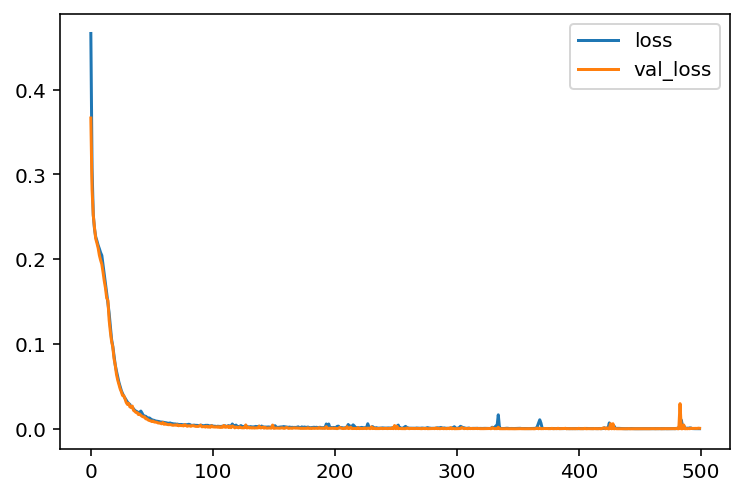

In [15]:
utils.plot_history(nn_history, ['loss', 'val_loss'])
#优化过程是找函数的全局最小值
#gradient decent可能会停留在局部最小值，除非调大learning rate跨过去小坡
#通过保留上一步的gradient，adam保留惯性，使得在局部最低点时能冲过小坡

In [16]:
nn_model.evaluate(test_x, test_y)

200/200 [==============================] - 0s 68us/sample - loss: 6.5186e-04 - acc: 1.0000


[0.0006518554305694124, 1.0]

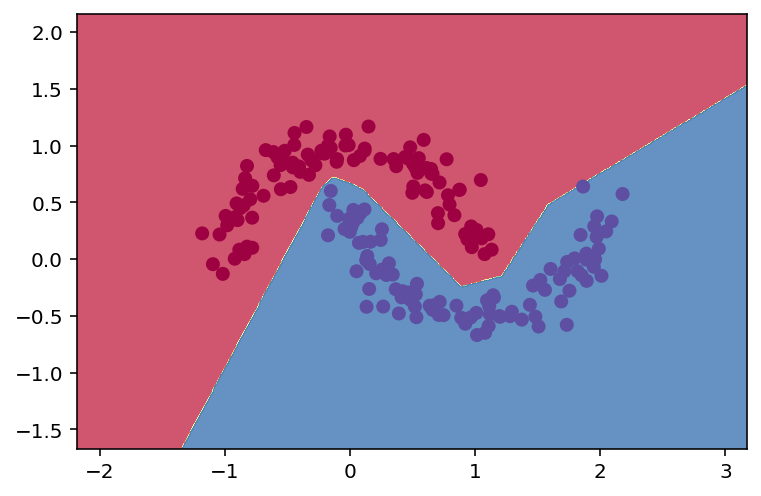

In [17]:
utils.plot_decision_boundary(nn_model, test_x, test_y)

## Word Embedding

<img src="resources/word-vector.png" width="800">

wordembedding
1.解决向量稀疏性问题：将每一个单词转换成致密的向量，并且少零且每一个数字都有意义
2.保留单词含义和变形

### Emoji Classifier

<img src="resources/emoji.png" width="800">

In [32]:
train_x, test_x, train_y, test_y = utils.load_emoji()

In [33]:
# Download and load word embeddings
# This util function returns two dict: word_to_index and word_to_vec
# At this moment, we only need the second part
_, word_to_vec_map = utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [34]:
# Print the first 5 samples
for i in range(5):
    print(train_x[i], utils.label_to_emoji(train_y[i]))

never talk to me again 😞
I am proud of your achievements 😄
It is the worst day in my life 😞
Miss you so much ❤️
food is life 🍴


In [35]:
# Convert output to one hot vector
train_y_oh = utils.convert_to_one_hot(train_y, 5)
test_y_oh = utils.convert_to_one_hot(test_y, 5)

print(train_y[0], "is converted into one hot", train_y_oh[0])

3 is converted into one hot [0. 0. 0. 1. 0.]


In [36]:
avg = utils.sentence_to_avg("I like it", word_to_vec_map)
avg
#word enbedding的长度为50，所以每个单词加起来求平均之后依然是一个长度为50的向量

array([ 0.36627333,  0.04672333, -0.138081  , -0.24937467,  0.48939667,
        0.04623667, -0.47231333, -0.14826667, -0.457185  ,  0.20397252,
       -0.10503   ,  0.60011667, -0.61682667, -0.1575    ,  0.78038333,
        0.55919   ,  0.29008333,  0.34581633, -0.22630233, -0.70794   ,
       -0.30531333,  0.34949667,  0.46258333,  0.234054  ,  0.63990667,
       -2.12683333, -1.06518   ,  0.45987   ,  0.74048667, -0.92987667,
        3.59586667,  0.33653667, -0.282609  , -0.01870267, -0.19816133,
       -0.202     ,  0.05308333,  0.35650667,  0.30246667, -0.23844333,
       -0.07741177,  0.226214  , -0.09908807,  0.37313   ,  0.06784867,
        0.37182667, -0.147618  , -0.43038933, -0.25390733,  0.44703333])

In [37]:
train_x = np.array(
    [utils.sentence_to_avg(x, word_to_vec_map) for x in train_x])

test_x = np.array(
    [utils.sentence_to_avg(x, word_to_vec_map) for x in test_x])

In [40]:
emoji_model = build_nn_model(
    input_dim=50, #每个句子都转化为了长度为50的向量
    layers=[50], #中间增加一层有50个神经元的hidden layer
    output_dim=5) #输出为one hot encoding形式，因此有五个class

emoji_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)#在carous中需要先compile model再train model

In [39]:
emoji_history = emoji_model.fit(
    train_x, 
    train_y_oh, 
    epochs=500, 
    shuffle=True, 
    validation_data=(test_x, test_y_oh), )

Train on 132 samples, validate on 56 samples
Epoch 1/500
132/132 [==============================] - 0s 1ms/sample - loss: 1.6523 - acc: 0.2424 - val_loss: 1.6879 - val_acc: 0.1607
Epoch 2/500
132/132 [==============================] - 0s 116us/sample - loss: 1.5941 - acc: 0.2803 - val_loss: 1.6457 - val_acc: 0.2500
Epoch 3/500
132/132 [==============================] - 0s 153us/sample - loss: 1.5516 - acc: 0.3561 - val_loss: 1.6136 - val_acc: 0.2500
Epoch 4/500
132/132 [==============================] - 0s 150us/sample - loss: 1.5203 - acc: 0.3864 - val_loss: 1.5862 - val_acc: 0.2679
Epoch 5/500
132/132 [==============================] - 0s 139us/sample - loss: 1.4913 - acc: 0.3939 - val_loss: 1.5628 - val_acc: 0.3214
Epoch 6/500
132/132 [==============================] - 0s 138us/sample - loss: 1.4644 - acc: 0.4167 - val_loss: 1.5400 - val_acc: 0.3750
Epoch 7/500
132/132 [==============================] - 0s 141us/sample - loss: 1.4389 - acc: 0.4167 - val_loss: 1.5190 - val_acc: 0.375

132/132 [==============================] - 0s 159us/sample - loss: 0.3334 - acc: 0.9242 - val_loss: 0.4691 - val_acc: 0.8214
Epoch 120/500
132/132 [==============================] - 0s 211us/sample - loss: 0.3262 - acc: 0.9242 - val_loss: 0.4632 - val_acc: 0.8214
Epoch 121/500
132/132 [==============================] - 0s 147us/sample - loss: 0.3217 - acc: 0.9091 - val_loss: 0.4590 - val_acc: 0.8214
Epoch 122/500
132/132 [==============================] - 0s 160us/sample - loss: 0.3200 - acc: 0.9091 - val_loss: 0.4580 - val_acc: 0.8214
Epoch 123/500
132/132 [==============================] - 0s 149us/sample - loss: 0.3173 - acc: 0.9167 - val_loss: 0.4532 - val_acc: 0.8214
Epoch 124/500
132/132 [==============================] - 0s 138us/sample - loss: 0.3161 - acc: 0.9015 - val_loss: 0.4539 - val_acc: 0.8214
Epoch 125/500
132/132 [==============================] - 0s 136us/sample - loss: 0.3118 - acc: 0.9091 - val_loss: 0.4514 - val_acc: 0.8214
Epoch 126/500
132/132 [==================

132/132 [==============================] - 0s 123us/sample - loss: 0.2209 - acc: 0.9545 - val_loss: 0.3863 - val_acc: 0.8393
Epoch 179/500
132/132 [==============================] - 0s 140us/sample - loss: 0.2278 - acc: 0.9470 - val_loss: 0.3852 - val_acc: 0.8393
Epoch 180/500
132/132 [==============================] - 0s 115us/sample - loss: 0.2242 - acc: 0.9470 - val_loss: 0.3826 - val_acc: 0.8393
Epoch 181/500
132/132 [==============================] - 0s 121us/sample - loss: 0.2159 - acc: 0.9621 - val_loss: 0.3949 - val_acc: 0.8393
Epoch 182/500
132/132 [==============================] - 0s 118us/sample - loss: 0.2200 - acc: 0.9545 - val_loss: 0.3969 - val_acc: 0.8393
Epoch 183/500
132/132 [==============================] - 0s 129us/sample - loss: 0.2204 - acc: 0.9545 - val_loss: 0.3884 - val_acc: 0.8571
Epoch 184/500
132/132 [==============================] - 0s 127us/sample - loss: 0.2165 - acc: 0.9621 - val_loss: 0.3812 - val_acc: 0.8571
Epoch 185/500
132/132 [==================

132/132 [==============================] - 0s 97us/sample - loss: 0.1609 - acc: 0.9773 - val_loss: 0.3488 - val_acc: 0.8571
Epoch 238/500
132/132 [==============================] - 0s 116us/sample - loss: 0.1596 - acc: 0.9773 - val_loss: 0.3465 - val_acc: 0.8571
Epoch 239/500
132/132 [==============================] - 0s 116us/sample - loss: 0.1593 - acc: 0.9773 - val_loss: 0.3445 - val_acc: 0.8571
Epoch 240/500
132/132 [==============================] - 0s 118us/sample - loss: 0.1591 - acc: 0.9773 - val_loss: 0.3439 - val_acc: 0.8571
Epoch 241/500
132/132 [==============================] - 0s 115us/sample - loss: 0.1584 - acc: 0.9773 - val_loss: 0.3446 - val_acc: 0.8571
Epoch 242/500
132/132 [==============================] - 0s 106us/sample - loss: 0.1565 - acc: 0.9773 - val_loss: 0.3519 - val_acc: 0.8571
Epoch 243/500
132/132 [==============================] - 0s 113us/sample - loss: 0.1576 - acc: 0.9773 - val_loss: 0.3581 - val_acc: 0.8571
Epoch 244/500
132/132 [===================

132/132 [==============================] - 0s 112us/sample - loss: 0.1284 - acc: 0.9848 - val_loss: 0.3068 - val_acc: 0.8571
Epoch 297/500
132/132 [==============================] - 0s 130us/sample - loss: 0.1265 - acc: 0.9848 - val_loss: 0.3222 - val_acc: 0.8571
Epoch 298/500
132/132 [==============================] - 0s 148us/sample - loss: 0.1209 - acc: 0.9848 - val_loss: 0.3311 - val_acc: 0.8571
Epoch 299/500
132/132 [==============================] - 0s 126us/sample - loss: 0.1259 - acc: 0.9848 - val_loss: 0.3479 - val_acc: 0.8571
Epoch 300/500
132/132 [==============================] - 0s 128us/sample - loss: 0.1284 - acc: 0.9848 - val_loss: 0.3292 - val_acc: 0.8571
Epoch 301/500
132/132 [==============================] - 0s 130us/sample - loss: 0.1216 - acc: 0.9848 - val_loss: 0.3115 - val_acc: 0.8571
Epoch 302/500
132/132 [==============================] - 0s 127us/sample - loss: 0.1181 - acc: 0.9848 - val_loss: 0.3102 - val_acc: 0.8393
Epoch 303/500
132/132 [==================

132/132 [==============================] - 0s 237us/sample - loss: 0.0954 - acc: 0.9848 - val_loss: 0.2960 - val_acc: 0.8393
Epoch 356/500
132/132 [==============================] - 0s 193us/sample - loss: 0.0934 - acc: 0.9848 - val_loss: 0.2978 - val_acc: 0.8571
Epoch 357/500
132/132 [==============================] - 0s 171us/sample - loss: 0.0936 - acc: 0.9848 - val_loss: 0.2971 - val_acc: 0.8571
Epoch 358/500
132/132 [==============================] - 0s 123us/sample - loss: 0.0927 - acc: 0.9848 - val_loss: 0.3010 - val_acc: 0.8393
Epoch 359/500
132/132 [==============================] - 0s 121us/sample - loss: 0.0927 - acc: 0.9848 - val_loss: 0.3094 - val_acc: 0.8393
Epoch 360/500
132/132 [==============================] - 0s 109us/sample - loss: 0.0943 - acc: 0.9848 - val_loss: 0.3038 - val_acc: 0.8393
Epoch 361/500
132/132 [==============================] - 0s 109us/sample - loss: 0.0934 - acc: 0.9848 - val_loss: 0.3047 - val_acc: 0.8571
Epoch 362/500
132/132 [==================

132/132 [==============================] - 0s 128us/sample - loss: 0.0741 - acc: 0.9848 - val_loss: 0.2982 - val_acc: 0.8571
Epoch 415/500
132/132 [==============================] - 0s 109us/sample - loss: 0.0742 - acc: 0.9848 - val_loss: 0.2885 - val_acc: 0.8571
Epoch 416/500
132/132 [==============================] - 0s 117us/sample - loss: 0.0744 - acc: 0.9848 - val_loss: 0.2782 - val_acc: 0.8393
Epoch 417/500
132/132 [==============================] - 0s 107us/sample - loss: 0.0768 - acc: 0.9848 - val_loss: 0.3008 - val_acc: 0.8393
Epoch 418/500
132/132 [==============================] - 0s 104us/sample - loss: 0.0746 - acc: 0.9848 - val_loss: 0.3172 - val_acc: 0.8393
Epoch 419/500
132/132 [==============================] - 0s 106us/sample - loss: 0.0734 - acc: 0.9848 - val_loss: 0.3210 - val_acc: 0.8393
Epoch 420/500
132/132 [==============================] - 0s 100us/sample - loss: 0.0723 - acc: 0.9848 - val_loss: 0.3189 - val_acc: 0.8393
Epoch 421/500
132/132 [==================

132/132 [==============================] - 0s 118us/sample - loss: 0.0568 - acc: 0.9924 - val_loss: 0.2956 - val_acc: 0.8393
Epoch 474/500
132/132 [==============================] - 0s 136us/sample - loss: 0.0562 - acc: 0.9848 - val_loss: 0.3016 - val_acc: 0.8393
Epoch 475/500
132/132 [==============================] - 0s 161us/sample - loss: 0.0571 - acc: 0.9924 - val_loss: 0.3106 - val_acc: 0.8393
Epoch 476/500
132/132 [==============================] - 0s 152us/sample - loss: 0.0563 - acc: 0.9924 - val_loss: 0.3050 - val_acc: 0.8393
Epoch 477/500
132/132 [==============================] - 0s 146us/sample - loss: 0.0565 - acc: 0.9924 - val_loss: 0.3001 - val_acc: 0.8393
Epoch 478/500
132/132 [==============================] - 0s 142us/sample - loss: 0.0574 - acc: 0.9924 - val_loss: 0.3097 - val_acc: 0.8393
Epoch 479/500
132/132 [==============================] - 0s 154us/sample - loss: 0.0571 - acc: 0.9924 - val_loss: 0.3084 - val_acc: 0.8393
Epoch 480/500
132/132 [==================

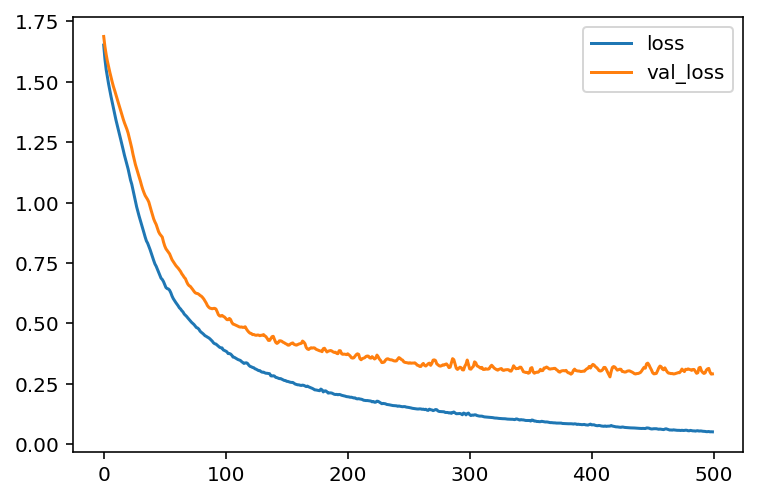

In [41]:
utils.plot_history(emoji_history, ['loss', 'val_loss'])
#val_loss似乎稳定在0.25，而trainning loss似乎还可以往下走。这意味着我们的模型足够复杂，可以overfitting
#traning loss:判断模型能力是否足够
#val——loss： 判断何时终止训练

In [44]:
def pred_emoji(text):
    embedding = np.array([utils.sentence_to_avg(text, word_to_vec_map)]) # get embedding
    pred = emoji_model.predict([embedding]) # predict, return the probability of each class
    label = np.argmax(pred) # choose the one with largest probability as label
    return utils.label_to_emoji(label)

In [46]:
tests = [
    "i love you", 
    "it's horrible", 
    "funny lol", 
    "lets play with a ball", 
    "food is ready", 
    "i don't like it"]#word embedding使得否定词丧失了最大的情感属性

for test in tests:
    print(test,pred_emoji(test))

i love you ⚾
it's horrible ⚾
funny lol ❤️
lets play with a ball ⚾
food is ready ⚾
i don't like it ⚾
